<a href="https://colab.research.google.com/github/dhavalsimaria/MachineLearning/blob/master/Anomaly%20Detection/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
from scipy import stats
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!pip install prince
import prince

In [4]:
from google.colab import files
import io

In [7]:
uploaded = files.upload()

Saving data-validation.xlsx to data-validation.xlsx


In [6]:
train_df = pd.read_excel(io.BytesIO(uploaded["data-train.xlsx"]))

In [8]:
test_df = pd.read_excel(io.BytesIO(uploaded["data-validation.xlsx"]))

In [28]:
X_train = train_df.filter(['category_id', 'price', 'currency', 'product_id'], axis=1)

In [29]:
X_test = test_df.filter(['category_id', 'price', 'currency', 'product_id'], axis=1)
y_test = test_df.filter(['isAnomaly'], axis=1)

## Multiple Correspondance Analysis (For scenarios with more than 2 Categorical predictors)

In [11]:
mca_model = prince.MCA(n_components=2,
                 n_iter=3,
                 copy=True,
                 check_input=True,
                 engine='auto',
                 random_state=42)

In [15]:
train_mca_df = pd.DataFrame(mca_model.fit_transform(X_train[['category_id', 'currency', 'product_id']]))
X_train = pd.concat([X_train, train_mca_df], axis=1)

In [16]:
test_mca_df = pd.DataFrame(mca_model.fit_transform(X_test[['category_id', 'currency', 'product_id']]))
X_test = pd.concat([X_test, test_mca_df], axis=1)

## Drop Categorical values after applying encoding

In [19]:
X_train = X_train.drop(columns=['category_id', 'currency', 'product_id'], axis=1)

In [20]:
X_test = X_test.drop(columns=['category_id', 'currency', 'product_id'], axis=1)

## Define Confusion Matrix method

In [21]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Define OC-SVM Model

In [22]:
classifier = OneClassSVM(kernel='rbf', nu=0.02, gamma='scale').fit(X_train)

## Define Isolation Forest Model

In [ ]:
#classifier=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.003), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0).fit(X_train)

## Predict Regular/Anomalous records over Test dataset

In [23]:
y_pred = classifier.predict(X_test)

## Evaluate results

In [24]:
test_df['predicted_anomaly'] = y_pred.tolist()
predicted_df = test_df.loc[test_df['predicted_anomaly'] == -1]
print(test_df.loc[test_df['isAnomaly'] == -1])

              _id category_id   price  ... product_id isAnomaly  predicted_anomaly
0     PXY87VWD9BX        CT02     700  ...       PD21        -1                  1
1209  PLP21VQR4XP        CT03  560000  ...       PD12        -1                  1
2400  PMP21VQR4XP        CT01  451000  ...       PD12        -1                  1
2401  PXY87VWD9BZ        CT02    2000  ...       PD22        -1                  1
2402  PAY87VWD9BY        CT02       1  ...       PD21        -1                 -1

[5 rows x 7 columns]


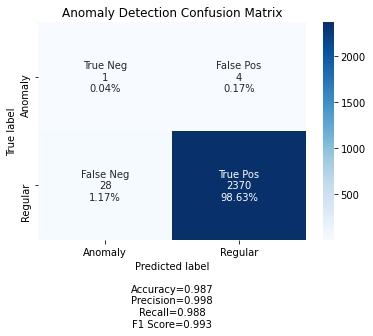

In [25]:
# Plot Confusion Matrix for the results
#--------------------------------------
title = 'Anomaly Detection Confusion Matrix'
cm = confusion_matrix(y_test, y_pred)
#print(cm)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Anomaly', 'Regular']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues', title=title)

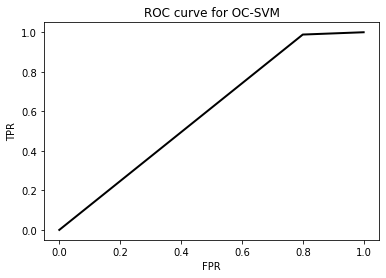

In [26]:
# Plot ROC curve for th results
#--------------------------------
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
title = 'ROC curve for OC-SVM' 
plt.title(title)
plt.savefig(title + ".jpg")
plt.show()